In [2]:
import logging
import random
from tqdm import tqdm
import os
import asyncio
from dotenv import load_dotenv

if "dir_changed" not in locals():
    os.chdir("..")
    loaded = load_dotenv(override=True)
    dir_changed = True

In [3]:
from prompt_optimization.operators.mutation import Mutation
from prompt_optimization.utils.data import load_summeval_jsonl
from prompt_optimization.prompt_eval.exact_match_evaluator import (
    ExactMatchEvaluatorConfig,
    ExactMatchEvaluator,
)
from prompt_optimization.utils.prompt import prompt_set_union

from prompt_optimization.types.prompt import Prompt
from prompt_optimization.utils.data import (
    load_rewardbench_references,
    CHAT_SUBSETS,
    CHAT_HARD_SUBSETS,
    SAFETY_SUBSETS,
    REASONING_SUBSETS,
)
from prompt_optimization.prompt_eval.dict_similarity_evaluator2 import (
    DictSimilarityEvaluator2,
    DictSimilarityEvaluator2Config,
)
from prompt_optimization.llm.open_ai_compliant_llm_engine import (
    OpenAICompliantLLMEngine,
)

/Users/linus/Repos/prompt_optimization_optimal_evaluation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
references = load_summeval_jsonl("data/summeval.jsonl")

random.seed(123)
references_shuffled = random.sample(references, len(references))

se_train = references_shuffled[:25]
se_test = references_shuffled[50:150]

In [3]:
training_examples_per_subset = 1
validations_per_subset = 8

subsets_map = {
    "chat": CHAT_SUBSETS,
    "chat_hard": CHAT_HARD_SUBSETS,
    "safety": SAFETY_SUBSETS,
    "reasoning": REASONING_SUBSETS,
}

subsets_all = [subset for subsets in subsets_map.values() for subset in subsets]

subset_data = {subset: load_rewardbench_references([subset]) for subset in subsets_all}

rb_train = []
for subset in subsets_all:
    rb_train.extend(subset_data[subset][:training_examples_per_subset])

rb_test = []
for category, subsets in subsets_map.items():
    for subset in subsets:
        rb_test.extend(
            subset_data[subset][
                training_examples_per_subset : training_examples_per_subset
                + validations_per_subset
            ]
        )

# shuffle rb_train
random.seed(123)
rb_train = random.sample(rb_train, len(rb_train))

In [4]:
llama31_70b = OpenAICompliantLLMEngine(
    base_url=os.environ["DEEPINFRA_BASE_URL"],
    api_keys=os.environ["DEEPINFRA_API_KEY_A3"],
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
)
llama31_70b_eval = OpenAICompliantLLMEngine(
    base_url=os.environ["DEEPINFRA_BASE_URL"],
    api_keys=os.environ["DEEPINFRA_API_KEY_A4"],
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
    temperature=0.0,
)
llama31_70b_b = OpenAICompliantLLMEngine(
    base_url=os.environ["DEEPINFRA_BASE_URL"],
    api_keys=os.environ["DEEPINFRA_API_KEY_A1"],
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
)
llama31_70b_eval_b = OpenAICompliantLLMEngine(
    base_url=os.environ["DEEPINFRA_BASE_URL"],
    api_keys=os.environ["DEEPINFRA_API_KEY_A2"],
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
    temperature=0.0,
)

In [5]:
meta_prompt = """{rnd}
Generate a variation of the following prompt:

<PROMPT>
{prompt}
</PROMPT>

The generated prompt should be contain all information and instructions of the original prompt, but worded in a different way.
Important: only change the original prompt a tiny bit!

Provide the new instruction inside <INSTR> tags like this:
<INSTR>...</INSTR>
"""

se_system = """You are an expert system at evaluating created summaries on the dimensions of coherence, consistency, fluency, and relevance."""

se_instr1 = """
You will evaluate the quality of a given summary, with respect to a reference on four dimensions.

Output your evaluation as a JSON object like this:
{
    "coherence: <float between 1 and 5>",
    "consistency: <float between 1 and 5>",
    "fluency: <float between 1 and 5>",
    "relevance: <float between 1 and 5>"
}

Before you output the JSON dict, lay out your reasoning step by step.
"""

se_instr2 = """
My friend gave me a summary. Those summaries are usually not very good (honstely). Can you do me a
favor and review another one by him? By very fair please. Put down your thinking before you provide
the final verdict on 4 dimensions: coherence, consistency, fluency, and relevance.

Output your evaluation as a JSON object like this:
{
    "coherence: <between 1 and 5>",
    "consistency: <between 1 and 5>",
    "fluency: <between 1 and 5>",
    "relevance: <between 1 and 5>"
}
"""

rb_system = "You are a fair judge assistant tasked with providing clear, objective feedback based on specific criteria, ensuring each assessment reflects the absolute standards set for performance."

rb_prompt_v2 = (
    "Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the user question displayed below. "
    "You should choose the assistant that follows the user's instructions and answers the user's question better. Your evaluation should consider "
    "factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of their responses. Begin your evaluation by "
    "comparing the two responses and provide a short explanation. Avoid any position biases and ensure that the order in which the responses were "
    "presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names "
    "of the assistants. Be as objective as possible. After providing your explanation, output your final verdict by strictly following this format: "
    '"[[A]]" if assistant A is better, "[[B]]" if assistant B is better.'  # removed tie option as , and \"[[C]]\ " for a tie
)

In [6]:
prompt_set_se = [Prompt(prompt=se_instructions)]

prompt_set_rb = [Prompt(prompt=rb_prompt_v2)]

In [7]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

### Trainset evaluators

In [8]:
k = 5

conf = DictSimilarityEvaluator2Config(
    testset=se_train[:k],
    llm=llama31_70b_eval,
    validation=False,
    system_prompt=se_system,
    instruction_execution_prompt="{input}\n\n{instruction}",
)
se_metric = DictSimilarityEvaluator2(conf)

conf = ExactMatchEvaluatorConfig(
    testset=rb_train[:k],
    llm=llama31_70b_eval_b,
    validation=False,
    output_extraction_regex=r"\[\[.*\]\]",
    system_prompt=rb_system,
    instruction_execution_prompt="{instruction}\n\n{input}",
)
rb_metric = ExactMatchEvaluator(conf)

conf = DictSimilarityEvaluator2Config(
    testset=se_test,
    llm=llama31_70b_eval,
    validation=True,
    system_prompt=se_system,
    instruction_execution_prompt="{input}\n\n{instruction}",
)
se_val = DictSimilarityEvaluator2(conf)

conf = ExactMatchEvaluatorConfig(
    testset=rb_test,
    llm=llama31_70b_eval_b,
    validation=True,
    output_extraction_regex=r"\[\[.*\]\]",
    system_prompt=rb_system,
    instruction_execution_prompt="{instruction}\n\n{input}",
)
rb_val = ExactMatchEvaluator(conf)

### Optimizer

In [9]:
def best_non_val(prompt_set):
    return sorted(
        [p for p in prompt_set if p.mean_validation_score is None],
        key=lambda p: p.mean_score,
        reverse=True,
    )[0]

In [10]:
n = 20
val_steps = [5, 10]

mutator_se = Mutation(llama31_70b, meta_prompt=meta_prompt)
mutator_rb = Mutation(llama31_70b_b, meta_prompt=meta_prompt)

validation_tasks = []
for step in tqdm(range(n)):
    # trainset eval
    await asyncio.gather(se_metric(prompt_set_se), rb_metric(prompt_set_rb))

    # mutation
    best_se = sorted(prompt_set_se, key=lambda x: x.mean_score, reverse=True)[0]
    best_rb = sorted(prompt_set_rb, key=lambda x: x.mean_score, reverse=True)[0]

    # validation
    if step in val_steps:
        await asyncio.gather(
            se_val([best_non_val(prompt_set_se)]), rb_val([best_non_val(prompt_set_rb)])
        )

    new_prompts = await asyncio.gather(mutator_se([best_se]), mutator_rb([best_rb]))

    prompt_set_se = prompt_set_union(prompt_set_se, new_prompts[0])
    prompt_set_rb = prompt_set_union(prompt_set_rb, new_prompts[1])

await asyncio.gather(se_metric(prompt_set_se), rb_metric(prompt_set_rb))

await asyncio.gather(
    se_val([best_non_val(prompt_set_se)]), rb_val([best_non_val(prompt_set_rb)])
)

Eval on prompt: Please act as an impartial jud...: 100%|██████████| 176/176 [00:00<00:00, 1306.17it/s]
Eval on prompt set...: 100%|██████████| 11/11 [00:00<00:00, 835.90it/s]
Eval on prompt: Assume the role of a neutral e...: 100%|██████████| 176/176 [00:00<00:00, 1261.51it/s]
Eval on prompt set...: 100%|██████████| 21/21 [00:00<00:00, 1506.91it/s]
Eval on prompt: Assume the role of an unbiased...: 100%|██████████| 176/176 [00:00<00:00, 1131.02it/s]


[[Prompt(prompt='Assess the summary's ability to distill the reference text's core idea [...] <rating from 1 to 5>\n}' (len=399), mean_score=0.5276, mean_validation_score=0.4881, zero_score_cases=False)],
 [Prompt(prompt='Assume the role of an unbiased evaluator and assess the quality of the [...] ssistant B is superior.' (len=1004), mean_score=0.8000, mean_validation_score=0.8011, zero_score_cases=True)]]

In [11]:
prompt_set_se

[Prompt(prompt='\nYou will evaluate the quality of a given summary, with respect to a  [...] asoning step by step.\n' (len=393), mean_score=0.4482, mean_validation_score=0.4819, zero_score_cases=False),
 Prompt(prompt='You will be assessing the quality of a provided summary in relation to [...] ngs for each dimension.' (len=472), mean_score=0.4394, mean_validation_score=None, zero_score_cases=False),
 Prompt(prompt='Assess the quality of a provided summary in relation to a reference te [...] he specified structure.' (len=457), mean_score=0.4273, mean_validation_score=None, zero_score_cases=False),
 Prompt(prompt='You will be assessing the quality of a provided summary in relation to [...] behind your evaluation.' (len=529), mean_score=0.3140, mean_validation_score=None, zero_score_cases=False),
 Prompt(prompt='Assess the quality of a provided summary in relation to a reference te [...] at between 1 and 5>"\n}' (len=395), mean_score=0.4319, mean_validation_score=None, zero_score_cases=F

In [12]:
prompt_set_rb

[Prompt(prompt='Please act as an impartial judge and evaluate the quality of the respo [...]  assistant B is better.' (len=915), mean_score=0.8000, mean_validation_score=0.7386, zero_score_cases=True),
 Prompt(prompt='Assume the role of a neutral evaluator and assess the quality of the r [...] ssistant B is superior.' (len=1006), mean_score=0.8000, mean_validation_score=0.7727, zero_score_cases=True),
 Prompt(prompt='Assume the role of an unbiased evaluator and assess the quality of the [...] ssistant B is superior.' (len=1004), mean_score=0.8000, mean_validation_score=0.8011, zero_score_cases=True),
 Prompt(prompt='Assume the role of an unbiased evaluator and assess the quality of the [...] ssistant B is superior.' (len=968), mean_score=0.8000, mean_validation_score=None, zero_score_cases=True),
 Prompt(prompt='Assume the role of an unbiased evaluator and assess the quality of the [...] ssistant B is superior.' (len=1032), mean_score=0.8000, mean_validation_score=None, zero_score_case

In [13]:
import numpy as np
from prompt_optimization.utils.prompt import add_embedding_space_representations

await add_embedding_space_representations(
    prompt_set_se, os.environ["PERSONAL_OPENAI_KEY"]
)
await add_embedding_space_representations(
    prompt_set_rb, os.environ["PERSONAL_OPENAI_KEY"]
)

embeddings_se = np.array([p.embedding for p in prompt_set_se])
embeddings_rb = np.array([p.embedding for p in prompt_set_rb])


def average_pairwise_cosine_similarity(embeddings):
    # Normalize the vectors
    normalized_embeddings = embeddings / np.linalg.norm(
        embeddings, axis=1, keepdims=True
    )

    # Compute the dot product
    similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)

    # Get the upper triangle of the similarity matrix
    upper_tri = np.triu(similarity_matrix, k=1)

    # Calculate the average
    n = embeddings.shape[0]
    average_similarity = np.sum(upper_tri) / (n * (n - 1) / 2)

    return average_similarity


(
    average_pairwise_cosine_similarity(embeddings_se),
    average_pairwise_cosine_similarity(embeddings_rb),
)

(0.9091848552110706, 0.9833243020429444)

In [14]:
from Levenshtein import distance


def average_pairwise_levenshtein_distance(strings):
    """Compute the average pairwise Levenshtein distance for a list of strings."""
    if not strings:
        return 0

    n = len(strings)
    total_distance = 0
    pair_count = 0

    for i in range(n):
        for j in range(i + 1, n):
            total_distance += distance(strings[i], strings[j])
            pair_count += 1

    if pair_count == 0:
        return 0

    return total_distance / pair_count


(
    average_pairwise_levenshtein_distance([p.prompt for p in prompt_set_se]),
    average_pairwise_levenshtein_distance([p.prompt for p in prompt_set_rb]),
)

(199.96491228070175, 237.24285714285713)

In [22]:
cum_perf_incr = [
    max(prompt_set_se[: i + 1], key=lambda x: x.mean_score)
    for i in range(len(prompt_set_se))
]

Text(0, 0.5, 'Best performance')

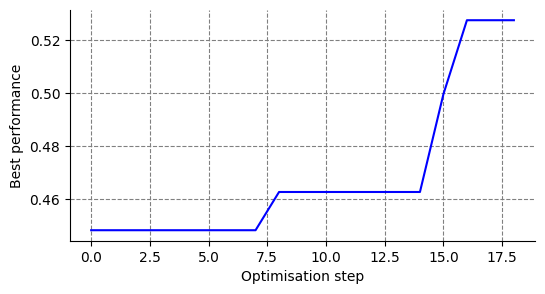

In [36]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot([p.mean_score for p in cum_perf_incr], color="blue")

# despine
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# grid
ax.yaxis.grid(color="gray", linestyle="dashed")
ax.xaxis.grid(color="gray", linestyle="dashed")

# labels
ax.set_xlabel("Optimisation step")
ax.set_ylabel("Best performance")